In [1]:
using Pkg; Pkg.activate(joinpath(@__DIR__, ".."))

  Activating project at `~/research/SolidStateFormationFlying`


In [2]:
import SatelliteDynamics

include("../src/satellite_simulator.jl")
include("../src/detumble_controller.jl")
include("../src/satellite_models.jl")



SatelliteModel(1.0, [0.0001959 2.016333e-6 2.69176e-7; 2.016333e-6 0.0001999 2.318659e-6; 2.69176e-7 2.318659e-6 0.0001064], [0.0, 0.0, 0.0], SatelliteFace[], 0.0, 0.0, 0.0, [0.0088, 0.01373, 0.0082])

In [3]:
using Plots
gr()

Plots.GRBackend()

# Impact of infrequent sensing on detumble control

------
# Simulation Experiments

In [4]:
params = OrbitDynamicsParameters(py4_model;
    distance_scale=1.0,
    time_scale=1.0,
    angular_rate_scale=1.0,
    control_scale=1,
    control_type=:dipole,
    magnetic_model=:IGRF13,
    add_solar_radiation_pressure=true,
    add_sun_thirdbody=true,
    add_moon_thirdbody=true)

# x_osc_0 = [400e3 + SatelliteDynamics.R_EARTH, 0.0, deg2rad(50), deg2rad(-1.0), 0.0, 0.0] # a, e, i, Ω, ω, M
x_osc_0 = [525e3 + SatelliteDynamics.R_EARTH, 0.0001, deg2rad(97.6), deg2rad(-1.0), 0.0, 45.0] # a, e, i, Ω, ω, M
q0 = [1.0, 0.0, 0.0, 0.0]
ω0 = [deg2rad(20), deg2rad(-30), deg2rad(10)]
ω0_slow = 0.1 * [deg2rad(20), deg2rad(-30), deg2rad(10)]

tspan = (0.0, 5 * 60 * 60.0)
x0 = state_from_osc(x_osc_0, q0, ω0)
x0_slow = state_from_osc(x_osc_0, q0, ω0_slow)

13-element Vector{Float64}:
       3.611068182649912e6
 -840051.7877863818
       5.822609767771629e6
   -6474.762908926636
    -414.9620218278771
    3956.4190910405464
       1.0
       0.0
       0.0
       0.0
       0.03490658503988659
      -0.05235987755982988
       0.017453292519943295

In [5]:
k_bcross = bcross_gain(x_osc_0, params)

1.6118505758951796e-5

In [6]:
xhist_bcross, uhist_bcross, thist_bcross = simulate_satellite_orbit_attitude_rk4(x0, params, tspan; integrator_dt=0.1, controller=(x, t, m) -> bcross_control(x, t, m; k=k_bcross, saturate=true), controller_dt=0.0)

([3.611068182649912e6 3.61042068444885e6 … -2.81172696551273e6 -2.81242098603331e6; -840051.7877863818 -840093.2788911278 … -777339.60127864 -777284.745047699; … ; -0.5235987755982988 -0.5252905425931259 … 1.0649026326688206e-11 1.0653321635171122e-11; 0.17453292519943295 0.1763883788410185 … 2.479914179961033e-11 2.47885318087391e-11], [0.06997731147540984 0.06997731147540984 … 4.587131305420108e-12 4.587131305420108e-12; 0.04735254753259303 0.04031510891664922 … -8.085479590069617e-12 -8.085479590069617e-12; -0.06976756111111111 -0.06976756111111111 … -6.177125036762041e-12 -6.177125036762041e-12], [0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9  …  17999.0, 17999.100000000002, 17999.2, 17999.3, 17999.4, 17999.5, 17999.600000000002, 17999.7, 17999.8, 18000.0])

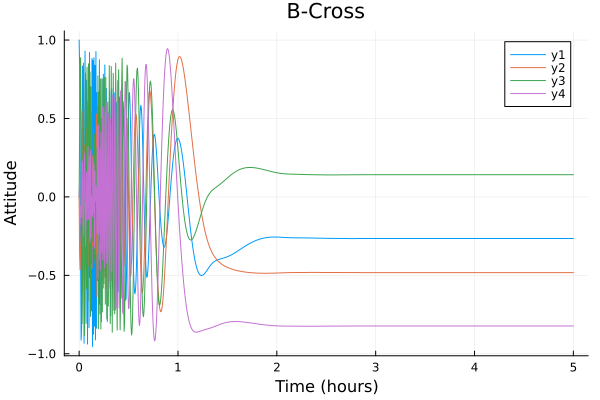

In [7]:
plot_attitude(thist_bcross, xhist_bcross; title="B-Cross")

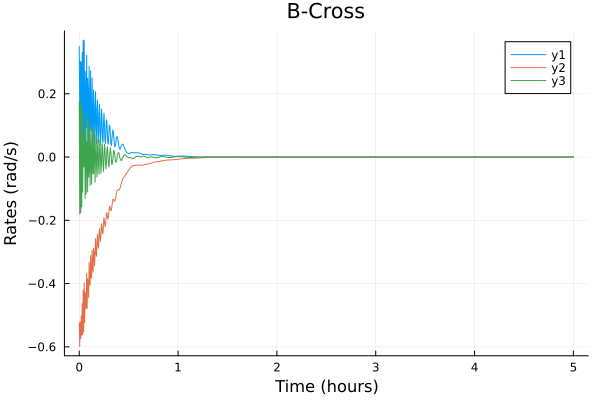

In [8]:
plot_rates(thist_bcross, xhist_bcross; title="B-Cross")

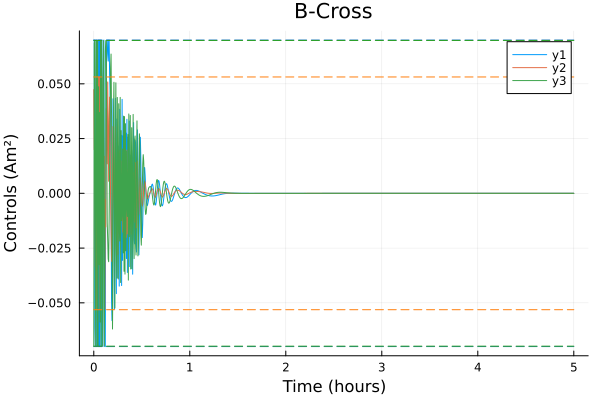

In [9]:
plot_controls(thist_bcross, uhist_bcross; title="B-Cross")

### With sensing delay - $\omega_0$ fast

In [10]:
bcross_control_sensed(x, t, params) = magnetic_control_sensed(
    (x_, t_, p_, B_) -> bcross_control(x_, t_, p_; B=B_, k=k_bcross, saturate=true),
    x,
    t,
    params;
    sensor_ticks = 100
)

xhist_bcross_sensed, uhist_bcross_sensed, thist_bcross_sensed = simulate_satellite_orbit_attitude_rk4(x0, params, tspan; integrator_dt=0.1, controller=bcross_control_sensed, controller_dt=0.0)

([3.611068182649912e6 3.61042068444885e6 … -2.8117702861470967e6 -2.81246430494213e6; -840051.7877863818 -840093.2788911278 … -777334.9698961641 -777280.1129372343; … ; -0.5235987755982988 -0.525373901384924 … -0.5882815007797597 -0.5881998197284648; 0.17453292519943295 0.17633150482868348 … -0.0028392481105253132 -0.0028407856268773558], [0.0 0.06997731147540984 … -0.05441527686458331 -0.05441527686458331; 0.0 0.04601203201762507 … -0.021339069900254182 -0.021339069900254182; 0.0 -0.06976756111111111 … -0.06976756111111111 -0.06976756111111111], [0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9  …  17999.0, 17999.100000000002, 17999.2, 17999.3, 17999.4, 17999.5, 17999.600000000002, 17999.7, 17999.8, 18000.0])

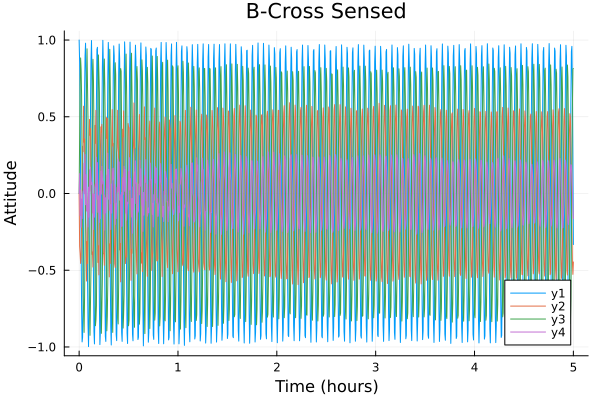

In [11]:
plot_attitude(thist_bcross_sensed, xhist_bcross_sensed; title="B-Cross Sensed")

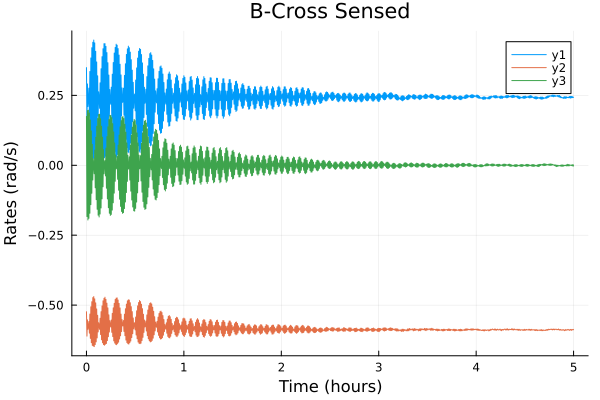

In [12]:
plot_rates(thist_bcross_sensed, xhist_bcross_sensed; title="B-Cross Sensed")

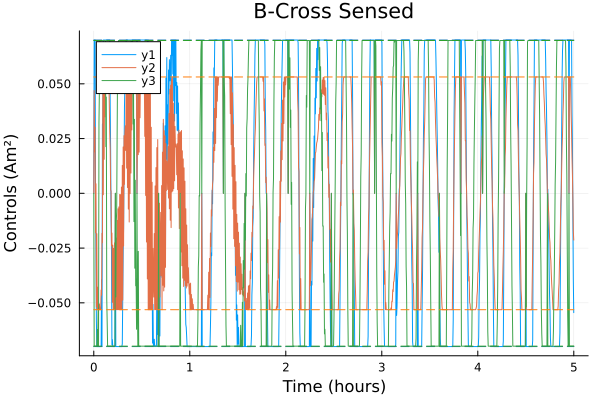

In [13]:
plot_controls(thist_bcross_sensed, uhist_bcross_sensed; title="B-Cross Sensed", max_samples=1117)

### With sensing delay - $\omega_0$ slow

In [14]:
bcross_control_sensed(x, t, params) = magnetic_control_sensed(
    (x_, t_, p_, B_) -> bcross_control(x_, t_, p_; B=B_, k=k_bcross, saturate=true),
    x,
    t,
    params;
    sensor_ticks = 100
)

xhist_bcross_sensed, uhist_bcross_sensed, thist_bcross_sensed = simulate_satellite_orbit_attitude_rk4(x0_slow, params, tspan; integrator_dt=0.1, controller=bcross_control_sensed, controller_dt=0.0)

([3.611068182649912e6 3.61042068444885e6 … -2.8117259620844587e6 -2.812419982630068e6; -840051.7877863818 -840093.2788911278 … -777339.4467650647 -777284.5904611034; … ; -0.05235987755982988 -0.052377582069831556 … 5.17663217688796e-12 5.176162073794113e-12; 0.017453292519943295 0.01747154054696693 … -6.5489113469174785e-12 -6.548927827389829e-12], [0.0 0.012109180893055604 … 3.9184188525607645e-13 3.9184188525607645e-13; 0.0 0.004721834548702042 … -1.4835673402874688e-12 -1.4835673402874688e-12; 0.0 -0.01001313592049243 … -9.502062431341831e-13 -9.502062431341831e-13], [0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9  …  17999.0, 17999.100000000002, 17999.2, 17999.3, 17999.4, 17999.5, 17999.600000000002, 17999.7, 17999.8, 18000.0])

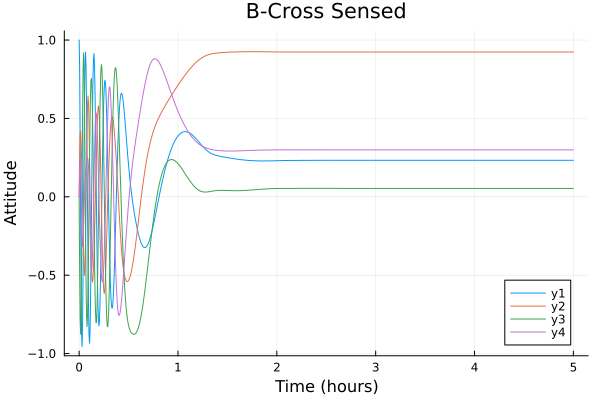

In [15]:
plot_attitude(thist_bcross_sensed, xhist_bcross_sensed; title="B-Cross Sensed")

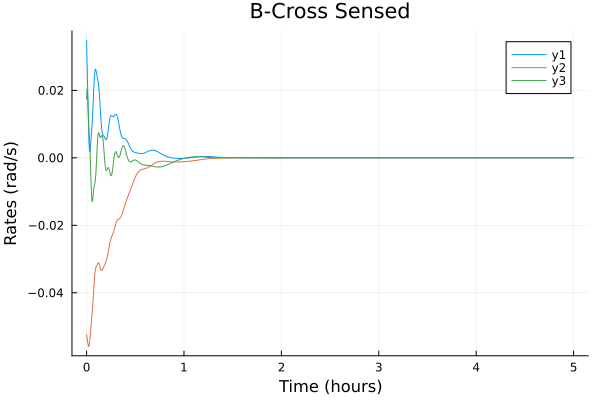

In [16]:
plot_rates(thist_bcross_sensed, xhist_bcross_sensed; title="B-Cross Sensed")

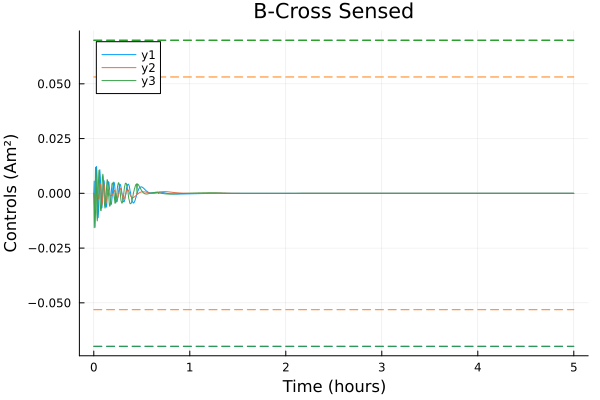

In [17]:
plot_controls(thist_bcross_sensed, uhist_bcross_sensed; title="B-Cross Sensed", max_samples=1117)

## Time Optimal

In [18]:
xhist_bopt, uhist_bopt, thist_bopt = simulate_satellite_orbit_attitude_rk4(x0, params, tspan; integrator_dt=0.1, controller=(x, t, m) -> boptimal_control(x, t, m; k=1.5e1, saturate=true), controller_dt=0.0)

([3.611068182649912e6 3.61042068444885e6 … -2.8117208137606345e6 -2.812414834843769e6; -840051.7877863818 -840093.2788911278 … -777339.4336712218 -777284.5774793819; … ; -0.5235987755982988 -0.5252907393618681 … -2.88216998937218e-10 -2.885268301856472e-10; 0.17453292519943295 0.17639152424177243 … -2.1928012918904082e-9 -2.1925244188886146e-9], [0.06997162020273352 0.06996910094366941 … 3.50150462731904e-10 3.50150462731904e-10; 0.051131601610646484 0.049586232625446265 … -2.5364478697700285e-10 -2.5364478697700285e-10; -0.06973479777427936 -0.06975132891125665 … -1.7196706853752018e-10 -1.7196706853752018e-10], [0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9  …  17999.0, 17999.100000000002, 17999.2, 17999.3, 17999.4, 17999.5, 17999.600000000002, 17999.7, 17999.8, 18000.0])

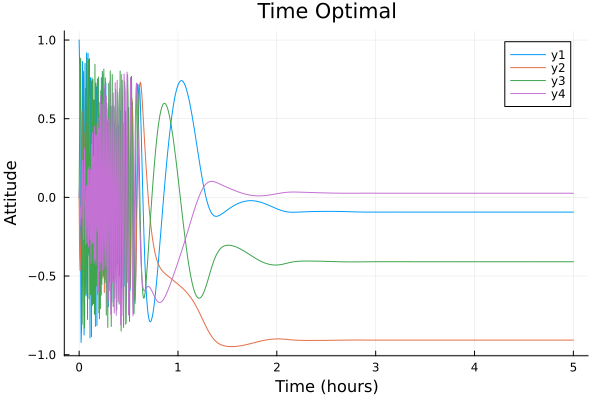

In [19]:
plot_attitude(thist_bopt, xhist_bopt; title="Time Optimal")

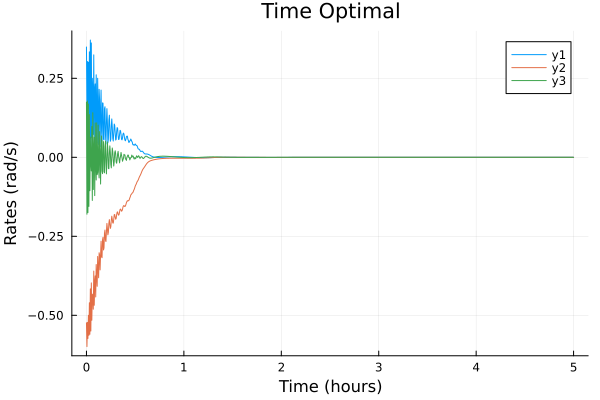

In [20]:
plot_rates(thist_bopt, xhist_bopt; title="Time Optimal")

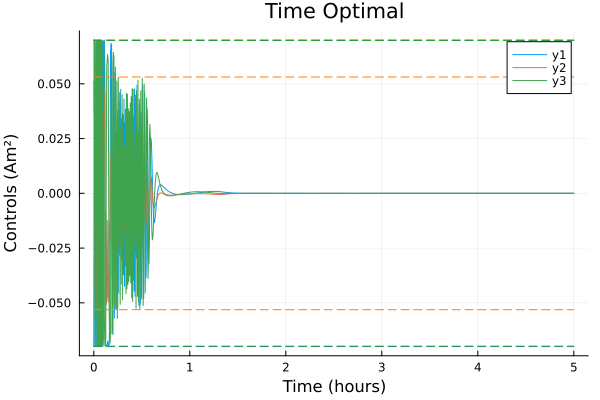

In [21]:
plot_controls(thist_bopt, uhist_bopt; title="Time Optimal")


### Sensor delay - $\omega_0$ fast

In [22]:
bopt_control_sensed(x, t, params) = magnetic_control_sensed(
    (x_, t_, p_, B_) -> boptimal_control(x_, t_, p_; B=B_, k=1.5e1, saturate=true),
    x,
    t,
    params;
    sensor_ticks = 100
)

xhist_bopt_sensed, uhist_bopt_sensed, thist_bopt_sensed = simulate_satellite_orbit_attitude_rk4(x0, params, tspan; integrator_dt=0.1, controller=bopt_control_sensed, controller_dt=0.0)

([3.611068182649912e6 3.61042068444885e6 … -2.8117601191936783e6 -2.812454138413684e6; -840051.7877863818 -840093.2788911278 … -777335.9804778151 -777281.1236704066; … ; -0.5235987755982988 -0.525373901384924 … -0.5853686744709615 -0.5853542527186287; 0.17453292519943295 0.17633150482868348 … 0.004502055187396232 0.004608061162191616], [0.0 0.06997177054457886 … -0.05910657867156983 -0.05910657867156983; 0.0 0.05089984449307002 … -0.028581834956138745 -0.028581834956138745; 0.0 -0.06973663510974577 … -0.06976756024513694 -0.06976756024513694], [0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9  …  17999.0, 17999.100000000002, 17999.2, 17999.3, 17999.4, 17999.5, 17999.600000000002, 17999.7, 17999.8, 18000.0])

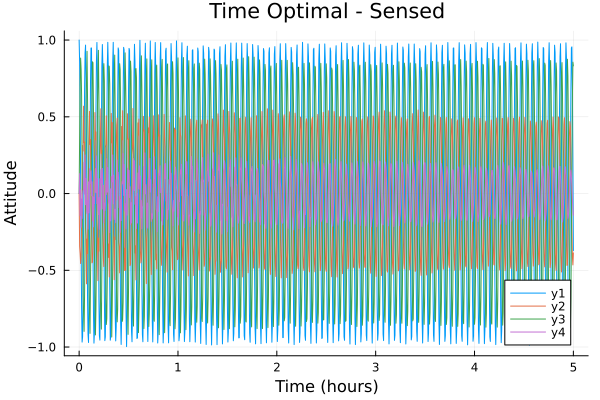

In [23]:
plot_attitude(thist_bopt_sensed, xhist_bopt_sensed; title="Time Optimal - Sensed")

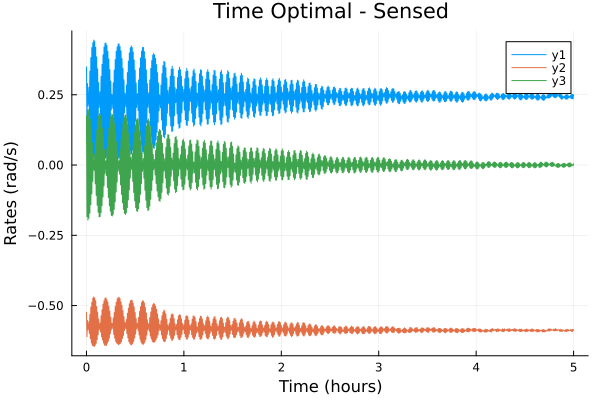

In [24]:
plot_rates(thist_bopt_sensed, xhist_bopt_sensed; title="Time Optimal - Sensed")

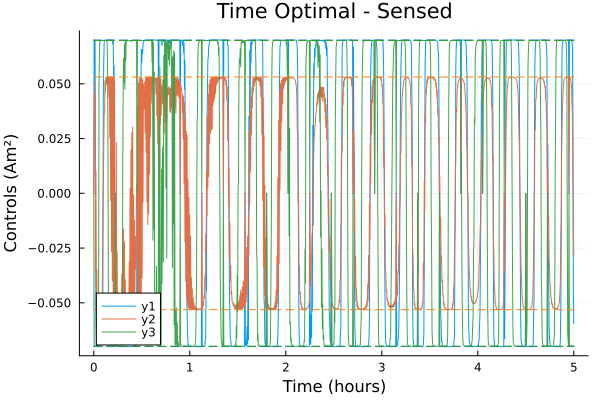

In [25]:
plot_controls(thist_bopt_sensed, uhist_bopt_sensed; title="Time Optimal - Sensed", max_samples=1117)


## With sensing delay - $\omega_0$ slow

In [26]:
bopt_control_sensed(x, t, params) = magnetic_control_sensed(
    (x_, t_, p_, B_) -> boptimal_control(x_, t_, p_; B=B_, k=1.5e1, saturate=true),
    x,
    t,
    params;
    sensor_ticks = 100
)

xhist_bopt_sensed, uhist_bopt_sensed, thist_bopt_sensed = simulate_satellite_orbit_attitude_rk4(x0_slow, params, tspan; integrator_dt=0.1, controller=bopt_control_sensed, controller_dt=0.0)

([3.611068182649912e6 3.61042068444885e6 … -2.811797885865333e6 -2.8124919034924977e6; -840051.7877863818 -840093.2788911278 … -777332.1311951621 -777277.2738077389; … ; -0.05235987755982988 -0.052377582069831556 … 1.020031473197671e-11 1.0181025019418339e-11; 0.017453292519943295 0.01747154054696693 … -7.417795206154679e-11 -7.418184998749025e-11], [0.0 0.03264715793719847 … 1.4009932013095689e-11 1.4009932013095689e-11; 0.0 0.010341840814421719 … -6.42658717744884e-12 -6.42658717744884e-12; 0.0 -0.027581929530581306 … 1.8607216489568357e-11 1.8607216489568357e-11], [0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9  …  17999.0, 17999.100000000002, 17999.2, 17999.3, 17999.4, 17999.5, 17999.600000000002, 17999.7, 17999.8, 18000.0])

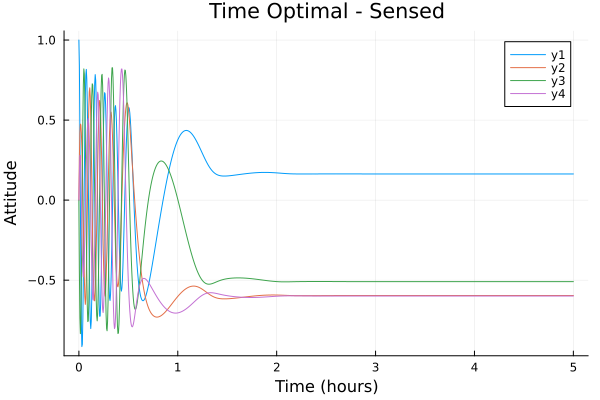

In [27]:
plot_attitude(thist_bopt_sensed, xhist_bopt_sensed; title="Time Optimal - Sensed")

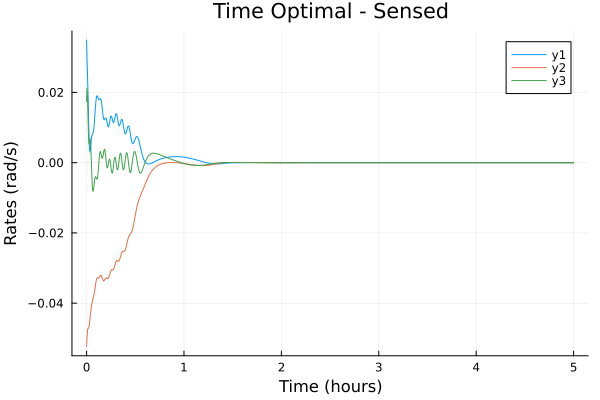

In [28]:
plot_rates(thist_bopt_sensed, xhist_bopt_sensed; title="Time Optimal - Sensed")

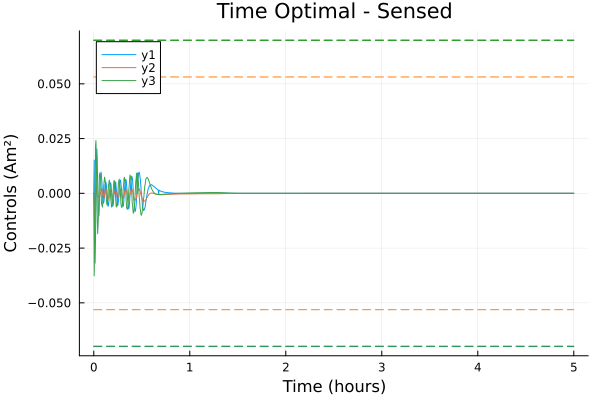

In [29]:
plot_controls(thist_bopt_sensed, uhist_bopt_sensed; title="Time Optimal - Sensed", max_samples=1117)


-----
# Findings
The value of `sensor_ticks` for which the controller will still converge is very dependent on the angular rate of the satellite. With `ω0 = 0.1 * [deg2rad(20), deg2rad(-30), deg2rad(10)]`, the controller converges for `sensor_ticks = 100`, but it does not with `ω0 =[deg2rad(20), deg2rad(-30), deg2rad(10)]` (10x that of the previous).

It seems that a safe sample rate is 1Hz. With a delay of ~0.03s between coils off and getting a good magnetometer reading, I'd say a 10 Hz controller would be a good choice. 

To make this legit/robust, we really need to include a state estimator/predictor that propagates the B field using angular rate measurements.